In [860]:
import numpy as np                                              # import numerical python
import matplotlib.pyplot as plt                                 # import plot library

# Scale Matters
A study into the 'fairness' of scaling large-scale assessments <br>
By: Gerard Barkema, Matthieu Brinkhuis & Berenice Michels

## Simulating a large-scale test
We simulate a test adminstered to *N* students, consisting of *M* items. <br>
The test is meant to measure a latent ability of the students $\theta$ which we assume to be normally distributed around a mean value <$\theta$> with a standard deviation $\sigma_\theta$. 

> simulation: change N, M, <$\theta$>, $\sigma_\theta$

In [861]:
# CHOOSE: define population_length as array length for population (N) 
# CHOOSE: and test_length as array lenght for test (M)
population_length = 87600                                       #N
test_length = 160                                             #M

# CHOOSE mean and standard deviation for ability 
ability_mean = 0.0                                              # theta_mean
ability_stddev = 1.0                                            # sigma_theta

# fill ability array
ability = np.random.normal(ability_mean,ability_stddev,population_length)
                                                                # array with random normally distributed abilities
ability_org = ability.copy()
#plt.hist(ability_org,bins=int(population_length/10))
#plt.xlabel("ability")
#plt.ylabel("number of students");    

We can choose to simulate a situation where part of the examinees gets 'better' (probably through extra education).<br>
In that case select: subsample = "Yes" <br> <br>
We divide the whole range of abilities in subsamples, defined by the distance to the mean.
The subsamples have a width of *n*$\sigma_\theta$, where *n* can be set. <br>
All abilities can be adjusted, or only part of the array, given by the number of items to take out of another (larger or same) number of items. <br>
The lower and upper border of the abilities that are to be corrected are given through edu_min and edu_max. Both will be multiplied with the width of the subsample and than added to the mean (so use negative numbers if you want to adjus the abilities below the mean.<br>
Finally, the effect of the extra education is represented by an amplification factor, relative to the standard deviation.
> simulation: sub (=width of subsample); take and out_of; edu_min and edu_max; amplif

In [862]:
 subsample = "No"
#subsample = "Yes"

# If Yes: define the width of the subsamples (as fraction of the standard deviation)
sub = 0.5                                        # width of subsample = sub*ability_stddev

# if Yes: define the portion of the subsamples to be 'educated extra'
# take = 1 out_of 3 means 1/3 is educated extra
take = 2
out_of = 3
portion = take/out_of

# If Yes: define what subsample(s) receives extra education'
# edu_min*sub*ability_stddev is the lower border of the students educated extra, 
# edu_max*sub*ability_stddev the upper border, borders not included
edu_min = -4.0
edu_max = +0.0

ability_min = ability_mean + (edu_min*sub*ability_stddev)
ability_max = ability_mean + (edu_max*sub*ability_stddev)
# print(ability_min, ability_max)

# If Yes: define the increment of ability due to the extra education
amplif = 1.0

edu_effect = amplif*ability_stddev

#if subsample == "Yes":
#    for (x) in range(population_length):
#         if (ability[x] > ability_min) & (ability[x] < ability_max):
#                ability[x] = ability[x] + edu_effect

#print(ability_min,ability_max)
if subsample == "Yes":
    n = 0
    while n < population_length:
        for (x) in range(out_of):
#            print("x = ",x)
            for y in range(take):
                if n < population_length:
#                    print("y = ",y)
#                    print("n = ",n)
#                    print(ability[n])
                    if ((ability[n] > ability_min) & (ability[n] < ability_max)):
#                        print("check")
                        ability[n] = ability[n] + edu_effect
#                        print(ability[n])
                    n = n+1
            n = n+(out_of-take)
#            print("n = ",n)
#        
#        print(out_of)
#        print(ability[x])
    
#plt.hist(ability,bins=int(population_length/10))
#plt.xlabel("ability")
#plt.ylabel("number of students");    

Each item *i* has a difficulty $\beta_i$. In accordance with general Item Response Theory (e.g. DeMars, 2010) the difficulty identifies the ability at which 50% of the students, taking the test, is expected to give a correct answer to the question. $\theta$ and $\beta$ are defined on the same metric. 
We can set the mean and standard deviation of the difficulty of the items in the test in comparison to that of the student's ability: $\Delta_\theta$ and $\Delta_\sigma$.

> simulation: change Δ𝜃 and Δ𝜎 <br>

In [863]:
# CHOOSE mean and standard deviation for difficulty (in relation to the ability values)
mean_dif = -1.5                                              # Delta_theta
stddev_dif = -0.5                                            # Delta_sigma
width = 0.5                                                 # for uniform distributions, set to 4*stddev of beta

In simulating the test, we assume that the probability *P* that student *i*  answers question *k*
correctly (and obtaines a score of 1), is given by the 1PL Item Response Function


$$
\\
\begin{equation}
P_{ik}=\frac{\exp((\theta_i-\beta_k)/\alpha)}{1+\exp((\theta_i-\beta_k)/\alpha))}
\end{equation}
%
$$

where $\alpha$ is a constant, denoting the discrimination of the items.

In [864]:
# define function IRF
def IRF(L,M,theta,beta,alfa):
#    L: integer - population size
#    M: integer - number of test items
#    theta: 2d-array of floats; shape (L,M) - abilities
#    beta = 2d-array of floats; shape (L,M) - difficulties
#    alfa = float - constant
    D = (theta - beta)/alfa
    IRF = np.exp(D)/(1+np.exp(D))
    return(IRF)

# CHOOSE alpha
alpha = 1.0

Now we run the test. 
We simulate that the population of students with ability $\theta$ takes the test with difficulties $\beta$.
We can run the simulation a number of times and average the outcomes

- set the number of tests we want to sample
- choose the distribution of the difficulties: normally random, uniformly random or uniformly


In [865]:
# CHOOSE number of iterations
sample = 1                                                   # number of iterations

P_test_score = np.zeros(population_length)
test_score = np.zeros(population_length)
p_values_test = np.zeros(test_length)

# set the difficulty mean and stddev
difficulty_mean = ability_mean + mean_dif                       # calculated mean of difficulties
difficulty_stddev = ability_stddev + stddev_dif                 # calculated standard deviation of difficulties
print(difficulty_mean, difficulty_stddev)

# start loop through 'sample' iterations
for x in range(sample):
#    print(x)

    
# CHOOSE distribution of difficulty
    
    # difficulty = np.random.normal(difficulty_mean, difficulty_stddev, test_length)                                                            # array with random **normally** distributed difficulties
   
    difficulty = np.random.uniform(low=difficulty_mean-width,high=difficulty_mean+width,size=test_length)
                                                              # array with random **uniformly** distributed difficulties
    
    #  difficulty = np.linspace(difficulty_mean-width,difficulty_mean+width,num=test_length,endpoint=True)
                                                              # array with linear **uniformly** distributed difficulties
    
#    plt.hist(difficulty_x, bins=int(test_length/10))
#    plt.xlabel("difficulty")
#    plt.ylabel("number of items");
     
#Calculate the probability of a correct score for every combination of student *i* and item *k*
    rs_ability = ability.reshape(population_length,1)
    rs_difficulty = difficulty.reshape(1,test_length)
    P_testresult=IRF(population_length,test_length,rs_ability,rs_difficulty,alpha)
#    print(rs_ability)
#    print(P_testresult)

# Calculate the testscore per student based on the probabilities per item
    P_test_score_x = np.sum(P_testresult,axis=1)
    P_test_score = P_test_score + P_test_score_x

# Determine for every student - item combination whether the student answers the item correctly (P>=0,5) or false (P<0.5)
#    testresult = np.rint(P_testresult)
 
# Determine for every student - item combination whether the student answers the item correctly:
# compare each probability P to a random generated probability R (uniform), 
# if P >= R the item score = 1; if P < R the item score = 0
    rand_compare = np.random.uniform(low=0,high=1,size=(population_length,test_length))
#    print(rand_compare)
#    print()
#    print(P_testresult)
    compare = P_testresult+1-rand_compare
#    print()
#    print(compare)
    testresult = np.trunc(compare)
#    print()
#    print(testresult)

    
# Calculate the testscore per student based on the item being correct (=1) or incorrect (=0)
    test_score_x = np.sum(testresult,axis=1)
    test_score = test_score + test_score_x
#    print()
#    print(test_score)
    
# Calculate the P-value per testitem based on the item being correct (=1) or incorrect (=0)
    p_values_test_x = np.sum(testresult,axis=0)
    p_values_test_x = p_values_test_x/population_length
    p_values_test = p_values_test + p_values_test_x

P_test_score = P_test_score/sample
test_score = test_score/sample
p_values_test = p_values_test/sample
sorted_p_values = np.sort(p_values_test)
sorted_p_values_x = np.sort(p_values_test_x)

# test_avg = np.average(test_score)
test_mean = np.mean(test_score)
test_std = np.std(test_score)

-1.5 0.5


In [866]:
# scale the results - linear transformation

scale_min = 500
scale_max = 550

scale_length = scale_max - scale_min
# print(scale_length)

scaled_score = (test_score/test_length)*scale_length + scale_min
scaled_mean = np.mean(scaled_score)
scaled_std = np.std(scaled_score)

N = 87600   M = 160
mean ability = 0.0    standdard deviation ability = 1.00
mean difficulty = -1.5   standdard deviation difficulty = 0.50   width distribution difficulty = 0.5

number of samples: 1
mean score = 124.27  standard deviation = 25.24
mean scaled score = 538.83  standard deviation scaled = 7.89


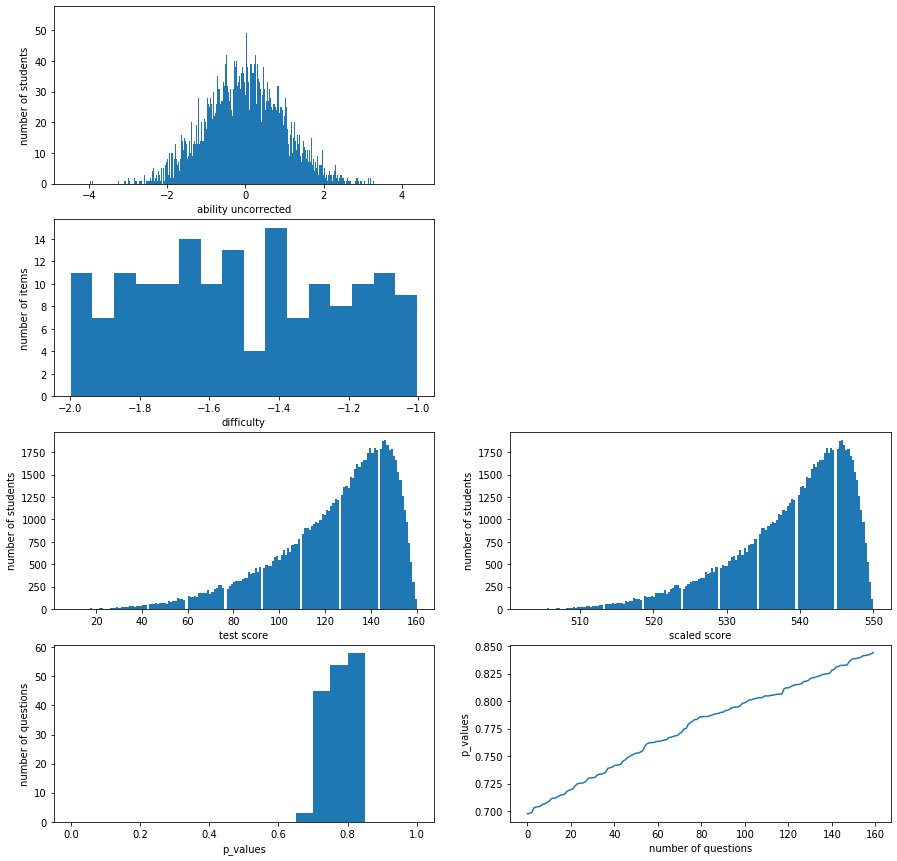

In [867]:
#Print output

plt.figure(figsize=(15,15))

plt.subplot(421)
plt.hist(ability_org,bins=int(population_length/10))
plt.xlabel("ability uncorrected")
plt.ylabel("number of students");

if subsample=="Yes":
    plt.subplot(422)
    plt.hist(ability,bins=int(population_length/10))
    plt.xlabel("ability new")
    plt.ylabel("number of students");

plt.subplot(423)
plt.hist(difficulty, bins=int(test_length/10))
plt.xlabel("difficulty")
plt.ylabel("number of items");

plt.subplot(425)
plt.hist(test_score,bins=int(test_length))
plt.xlabel("test score")
plt.ylabel("number of students");

plt.subplot(426)
plt.hist(scaled_score,bins=int(test_length))
plt.xlabel("scaled score")
plt.ylabel("number of students");

plt.subplot(427)
plt.hist(p_values_test,bins=20,range=(0,1))
plt.xlabel("p_values")
plt.ylabel("number of questions");

plt.subplot(428)
plt.plot(sorted_p_values)
plt.xlabel("number of questions")
plt.ylabel("p_values");

print("N = %.i   M = %.i"%(population_length,test_length))
print("mean ability = %.1f    standdard deviation ability = %.2f"%(ability_mean,ability_stddev))
print("mean difficulty = %.1f   standdard deviation difficulty = %.2f   width distribution difficulty = %.1f"
      %(difficulty_mean,difficulty_stddev,width))
if subsample=="Yes":
    print("abilities corr. between %.2f and %.2f, portion of population corrected = %.2f, amplification = %.2f "
          %(edu_min,edu_max,portion,edu_effect))
print()
print("number of samples: %.i"%(sample))
print("mean score = %.2f  standard deviation = %.2f"%(test_mean,test_std))
print("mean scaled score = %.2f  standard deviation scaled = %.2f"%(scaled_mean,scaled_std))